#### Demo of the Training pipeline

In [60]:
import os
import torch
import json
import random
import pyewts
import logging
import numpy as np
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
from glob import glob
from datetime import datetime
from natsort import natsorted
from torch.nn import CTCLoss
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image

import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

from IPython.display import Image as ShowImage
from src.Utils import create_dir, shuffle_data, resize_n_pad, read_data
from src.Models import VanillaCRNN
from src.Datasets import CTCDataset, ctc_collate_fn
from src.Augmentations import train_transform

from config import N_DEFAULT_CHARSET

logging.getLogger().setLevel(logging.INFO)

print(torch.__version__)

2.1.1


In [61]:
def show_image(image: np.array, cmap: str = "", axis="off") -> None:
    plt.figure(figsize=(24, 13))
    plt.axis(axis)
    
    if cmap != "":
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(image)

#### Setup Data

In [52]:
converter = pyewts.pyewts()
training_time = datetime.now()

data_dir = "D:/Datasets/Tibetan/JKW-SB/Datasets/Khyentse"
dataset_name = "Dataset_v1"
ds_dir = os.path.join(data_dir, dataset_name)

output_dir = os.path.join(ds_dir, "Output", f"{training_time.year}_{training_time.month}_{training_time.day}_{training_time.hour}_{training_time.minute}")
create_dir(output_dir)

images = natsorted(glob(f"{ds_dir}/lines/*.jpg"))
labels = natsorted(glob(f"{ds_dir}/transcriptions/*.txt"))

print(f"Images: {len(images)}, Labels:{len(labels)}")

images, labels = shuffle_data(images, labels)
images = images[:32000]
labels = labels[:32000]

train_images = images[:int(len(images)*0.8)]
train_labels = labels[:int(len(labels)*0.8)]

valid_images = images[int(len(images)*0.8):]
valid_labels = labels[int(len(labels)*0.8):]

print(f"Train Images: {len(train_images)}, Train Labels: {len(train_labels)}")
print(f"Valid Images: {len(valid_images)}, Valid Images: {len(valid_labels)}")

Images: 13527, Labels:13527
Train Images: 10821, Train Labels: 10821
Valid Images: 2706, Valid Images: 2706


In [53]:
# save train data
train_images_out = f"{output_dir}/train_images.txt"

with open(train_images_out, "w") as f:
    for img in train_images:
        img_n = os.path.basename(img).split(".")[0]
        f.write(f"{img_n}\n")

val_images_out = f"{output_dir}/val_images.txt"

with open(val_images_out, "w") as f:
    for img_n in valid_images:
        img_n = os.path.basename(img_n).split(".")[0]
        f.write(f"{img_n}\n")

In [66]:
train_images, train_labels = read_data(train_images, train_labels, converter, min_label_length=0, max_label_length=400)
valid_images, valid_labels = read_data(valid_images, valid_labels, converter, min_label_length=0, max_label_length=400)

print(f"Train Images: {len(train_images)}, Train Labels: {len(train_labels)}")
print(f"Valid Images: {len(valid_images)}, Valid Images: {len(valid_labels)}")

reading labels: 100%|██████████| 2706/2706 [00:02<00:00, 1086.21it/s]

Train Images: 10807, Train Labels: 10807
Valid Images: 2703, Valid Images: 2703


In [67]:
train_labels[:4]

["zhes§bshad§pa§yin§no//de§yang§kun§tu§bzang§po§la§sogs§pa§'bras§bu'i§ngo§bo§nyid§ni§yang§dag§rig§pa§las§tha§dad§pa§gzhan§dag§yod§pa§ma§yin§no//zhes§dang§/!yang§sgrub§thabs§de§nyid§kyi§'grel§pa§",
 "lam§du§byed§pa§la§gtso§bor§dgongs§nas§ye§shes§pa'i§thugs§rgyud§bde§ba§chen§po'i§gzi§byin§lhag§par§bskul§ba'i§phyir§bde§stong§gi§lha§sku§khro§mkhar§gyi§tshul§du§bsgom§pa§dang§/bye§brag§tu§yum§zhal§yab§kyi§rdo§",
 "gtan§la§mnyam§par§gnas§pas/rim§gyis§phyi§ma§rnams§kyang§snga§ma§la§thim§ste§bdag§skyes§bu§'ba'§zhig§gsal§bar§gnas§pa§ni§thar§pa§yin§par§'dod§la/des§na§de§kho§na§nyid§grangs§nyi§shu§rtsa§lngar§smra§bas§",
 "lung§las§ni//chos§nyid§gzhi'am§ma§bcos§pa//khyab§byed§de§la§'byung§ba§yi//'gro§drug§khyab§byar§gsungs§pa'o//zhes§dang§/nang§pa§mu§stegs§dbang§du§ni//rang§rig§'od§gsal§khyab§byed§de//"]

In [68]:
target_width = 2000
target_height = 80
batch_size = 32
num_workers = 4
persistent_workers = True
charset = N_DEFAULT_CHARSET

train_dataset = CTCDataset(images=train_images, labels=train_labels, img_height=target_height, img_width=target_width, charset=charset, augmentations=train_transform)
valid_dataset = CTCDataset(images=valid_images, labels=valid_labels, img_height=target_height, img_width=target_width, charset=charset)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=ctc_collate_fn,
    drop_last=True,
    num_workers=num_workers,
    persistent_workers=persistent_workers)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=ctc_collate_fn,
    drop_last=True,
    num_workers=num_workers,
    persistent_workers=persistent_workers)

In [69]:
# checking the loaders work correctly
train_sample = next(iter(train_loader))
valid_sample = next(iter(valid_loader))

(80, 2000, 1)


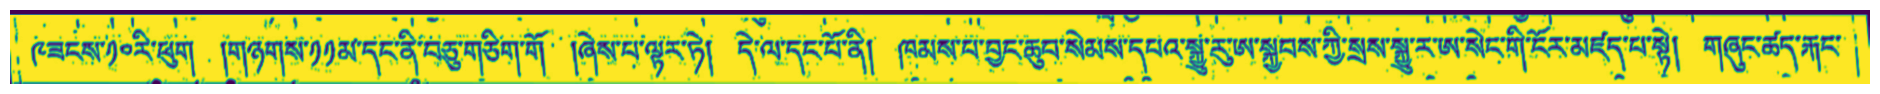

In [77]:
image, label, label_length = train_sample
image = image.numpy()
batch_img_idx = random.randint(0, 31)
n_image = image[batch_img_idx]
n_image = np.transpose(n_image, axes=[1, 2, 0])
print(n_image.shape)

show_image(n_image)

Define the Model and Training Parameters

In [78]:
"""
A collection of OCR architectures to be used by the pipeline.

"""
from torch import nn
from torch.nn import functional as F


"""
1. A classic implementation of a CRNN model using a CNN backbone with recurrent layers and ctc loss.
"""

class ConvRelu(nn.Module):
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel: int = 3, 
                 strides: int = 1, 
                 padding: int = 1, 
                 use_bn: bool = False,
                 dropout_rate: float = 0.2, 
                 leaky_relu: bool = False):
        super(ConvRelu, self).__init__()
        
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel, stride=strides, padding=padding)
        self.use_bn = use_bn
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.leaky_relu = leaky_relu
        self.dropout = nn.Dropout(p=dropout_rate)
        self.out_channels = out_channels

    def forward(self, x):
        x = self.conv2d(x)

        if self.use_bn:
            x = self.bn(x)

        if self.leaky_relu:
            x = nn.LeakyReLU(negative_slope=0.2)(x)
        else:
            x = nn.ReLU(inplace=True)(x)
        x = self.dropout(x)

        return x


class VanillaCRNN(nn.Module):

    def __init__(self, img_height: int = 80, img_width: int = 2000, img_channels: int = 1, charset_size: int = 68,
                 map_to_seq_hidden: int =64, rnn_hidden: int =256, leaky_relu: bool = False, rnn: str = "lstm"):
        super(VanillaCRNN, self).__init__()


        self.input_channels = img_channels
        self.input_height = img_height
        self.input_width = img_width
        self.classes = charset_size
        self.map_to_seq_hidden = map_to_seq_hidden

        self.conv_block_0= ConvRelu(in_channels=self.input_channels, out_channels=64, leaky_relu=leaky_relu)
        self.max_pool_0 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_block_1 = ConvRelu(in_channels=64, out_channels=128, leaky_relu=leaky_relu)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_block_2 = ConvRelu(in_channels=128, out_channels=256, leaky_relu=leaky_relu)
        self.conv_block_3 = ConvRelu(in_channels=256, out_channels=256, leaky_relu=leaky_relu)
        self.max_pool_2 = nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))

        self.conv_block_4= ConvRelu(in_channels=256, out_channels=512, use_bn=True, leaky_relu=leaky_relu)
        self.conv_block_5= ConvRelu(in_channels=512, out_channels=512, use_bn=True, leaky_relu=leaky_relu)
        self.max_pool_3 = nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))

        self.conv_block_6 = ConvRelu(in_channels=512, out_channels=512, kernel=2, padding=0,leaky_relu=leaky_relu)
        self.linear = nn.Linear(512 * ( self.input_height // 16 - 1), self.map_to_seq_hidden)

        if rnn == "lstm":
            self.rnn1 = nn.LSTM(map_to_seq_hidden, rnn_hidden, bidirectional=True)
            self.rnn2 = nn.LSTM(2 * rnn_hidden, rnn_hidden, bidirectional=True)
        else:
            self.rnn1 = nn.GRU(map_to_seq_hidden, rnn_hidden, bidirectional=True)
            self.rnn2 = nn.GRU(2 * rnn_hidden, rnn_hidden, bidirectional=True)

        self.dense = nn.Linear(2 * rnn_hidden, charset_size)


    def forward(self, images):
        x = self.conv_block_0(images)
        x = self.max_pool_0(x)
        x = self.conv_block_1(x)
        x = self.max_pool_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.max_pool_2(x)
        x = self.conv_block_4(x)
        x = self.conv_block_5(x)
        x = self.max_pool_3(x)
        x = self.conv_block_6(x)

        batch, channel, height, width = x.size()
        
        x = x.view(batch, channel * height, width)
        x = x.permute(2, 0, 1)
        x = self.linear(x)

        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        x = self.dense(x)

        return x

In [79]:
torch.cuda.empty_cache()

In [80]:
device = "cuda"
target_width = 2000
target_height = 80
map_to_seq_hidden = 64
rnn_hidden = 256
leaky_relu = False
learning_rate = 0.0005
num_classes = len(charset)+1
rnn = "lstm"

network = VanillaCRNN(rnn=rnn, charset_size=num_classes)
network.to(device)

optimizer = optim.RMSprop(network.parameters(), lr=learning_rate)
#lr_scheduler = ReduceLROnPlateau(optimizer, factor=0.8, patience=5, verbose=True)

criterion = CTCLoss(reduction='sum', zero_infinity=True)
criterion.to(device)

CTCLoss()

In [81]:
x = torch.randn([1, 1, 80, 2000], device=device, requires_grad=True)
network_out = network(x)

print(network_out.shape)

torch.Size([499, 1, 76])


#### Train Loop

In [82]:
def train_batch(network, data, optimizer, criterion, device):
    network.train()
    images, targets, label_lengths = [d.to(device) for d in data]

    logits = network(images)
    log_probs = torch.nn.functional.log_softmax(logits, dim=2)

    batch_size = images.size(0)
    input_lengths = torch.LongTensor([logits.size(0)] * batch_size)
    label_lengths = torch.flatten(label_lengths)

    loss = criterion(log_probs, targets, input_lengths, label_lengths)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(network.parameters(), 5) # gradient clipping with 5
    optimizer.step()

    return loss.item()

In [83]:
def save_checkpoint(network, optimizer, save_path):
    checkpoint = {"state_dict": network.state_dict(), "optimizer": optimizer.state_dict()}  
    torch.save(checkpoint, save_path)
    
    logging.info(f"Saved Model Checkpoint at {save_path}")


def check_accuracy(network, val_loader, criterion):
    val_ctc_losses = []
    network.eval()

    for _, val_data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        with torch.no_grad():
            images, targets, target_lengths = [d.to(device) for d in val_data]

            logits = network(images)
            log_probs = torch.nn.functional.log_softmax(logits, dim=2)

            batch_size = images.size(0)
            input_lengths = torch.LongTensor([logits.size(0)] * batch_size)
            target_lengths = torch.flatten(target_lengths)

            loss = criterion(log_probs, targets, input_lengths, target_lengths)
            val_ctc_losses.append(loss / batch_size)

    val_loss = torch.mean(torch.tensor(val_ctc_losses))
    network.train()

    return val_loss.item()

In [84]:
def train(network, train_loader, val_loader, checkpoint_path: str, epochs: int = 10):
    train_iteration = 1

    train_loss_history = []
    val_loss_history = []
    best_loss = None

    for epoch in range(1, epochs + 1):
        epoch_train_loss = 0
        tot_train_count = 0

        for _, data in tqdm(enumerate(train_loader), total=len(train_loader)):

            loss = train_batch(network, data, optimizer, criterion, device)
            train_size = data[0].size(0) # batch_size

            epoch_train_loss += loss
            tot_train_count += train_size

        train_iteration += 1

        train_loss = epoch_train_loss / tot_train_count
        train_loss_history.append(train_loss)

        val_loss = check_accuracy(network, val_loader, criterion)
        val_loss_history.append(val_loss)

        logging.info(f"Epoch {epoch} => train_loss: {train_loss}, val loss: {val_loss}")

        if best_loss is None:
            best_loss = val_loss
            save_checkpoint(network, optimizer, checkpoint_path)

        elif val_loss < best_loss:
            save_checkpoint(network, optimizer, checkpoint_path)

    return train_loss_history, val_loss_history

In [85]:
model_save_path = f"{output_dir}/{dataset_name}_jan2024.pth"
train_losses, val_losses = train(network, train_loader, valid_loader, model_save_path, epochs=2)

  0%|          | 0/337 [00:00<?, ?it/s]

  1%|          | 4/337 [01:18<1:48:13, 19.50s/it]


KeyboardInterrupt: 

#### Save Model data and training results

In [30]:
train_losses_out = f"{output_dir}/train_lossses_pt2.txt"
val_losses_out = f"{output_dir}/val_lossses_pt2.txt"

with open(train_losses_out, "w") as f:
  f.write(str(train_losses))

with open(val_losses_out, "w") as f:
  f.write(str(val_losses))

#### Evaluate model on test lines

In [5]:
import cv2
import pyewts
import torch
from evaluate import load
from src.Models import VanillaCRNN
from src.Utils import resize_n_pad
from fast_ctc_decode import viterbi_search

converter = pyewts.pyewts()
cer_scorer = load("cer")

pred_charset = f"ß{DEFAULT_CHARSET}"
old_pred_charset = f"ß{OLD_DEFAULT_CHARSET}"

In [9]:
checkpoint_path = "Checkpoints/2023_8_1_6_5"
checkpoint_file = "LhasaKanjur.pth"
inference_model = VanillaCRNN(rnn="lstm", charset_size=len(OLD_DEFAULT_CHARSET)+1)
checkpoint = torch.load(os.path.join(checkpoint_path, checkpoint_file))
inference_model.load_state_dict(checkpoint['state_dict'])

inference_model.eval()
cer_metric = load("cer")

In [10]:
test_lines_path = "Datasets\LhasaKanjur\TestLines"
test_lines = natsorted(glob(f"{test_lines_path}/*.jpg"))
gt_lines = natsorted(glob(f"{test_lines_path}/*.txt"))

print(f"Test images: {len(test_lines)}, Ground Truth labels: {len(gt_lines)}")

Test images: 11, Ground Truth labels: 11


In [16]:
dataset_path = "D:/Datasets/Tibetan/LhasaKanjur/LhasaKanjurProdigy_v1_reviewed"
chkpt_path = "Checkpoints/2023_9_13_7_59"
model_checkpoint = os.path.join(chkpt_path, "LhasaKanjur_prodigy_v2.pth")
train_set = os.path.join(chkpt_path, "test_imgs.txt")
val_set = os.path.join(chkpt_path, "val_imgs.txt")
test_set= os.path.join(chkpt_path, "test_imgs.txt")

In [17]:
def get_entries(file_path: str, test_data_path: str):
    with open(file_path, "r", encoding="utf-8") as f:
        entries = f.readlines()
        entries = [x.replace("\n", "") for x in entries]
        entries = [os.path.basename(x) for x in entries]
        entries = [x.split(".")[0] for x in entries]

        images = [f"{test_data_path}/lines/{x}.jpg" for x in entries]
        labels = [f"{test_data_path}/transcriptions/{x}.txt" for x in entries]

    return images, labels


test_images, test_labels = get_entries(test_set, dataset_path)

print(f"Test images: {len(test_images)}, Ground Truth labels: {len(test_labels)}")

Test images: 16064, Ground Truth labels: 16064


In [11]:
def prepare_test_image(image_path: str) -> torch.FloatTensor:
    t_img= cv2.imread(image_path, 0)
    t_img = resize_n_pad(t_img, target_height=80, target_width=2000, padding="white")
    t_img = (t_img / 127.5) - 1.0
    t_img = np.array(t_img)
    t_img = np.expand_dims(t_img, axis=0) # add channel dimension
    t_img = np.expand_dims(t_img, axis=0) # add channel batch dimension, so that: BxCxHxW
    t_img = torch.FloatTensor(t_img)

    return t_img

def read_label(gt_file: str) -> str:
    f = open(gt_file, "r", encoding="utf-8")
    return f.readline()

In [12]:
line_idx = 1
t_image = prepare_test_image(test_lines[line_idx])
predictions = inference_model(t_image)
np_predictions = predictions.cpu().detach().numpy()
np_predictions = np.squeeze(np_predictions, axis=1)

OCR: ཤེས་པ་ཞེ་སྡང་གི་ཆོས་ཉིད་ཀྱང་མ་ཡིན། ཞེ་སྡང་མེད་པའི་ཆོས་ཉིད་ཀྱང་མ་ཡིན་པ་གང་ཡིན་པ་དེ། ཤེས་རབ་ཀྱི་ཕ་རོལ་ཏུ་ཕྱིན་པའོ། །རབ་ཀྱི་རྩལ་གྱིས་རྣམ་པར་གནོན་པ། གཟུགས་ནི། གཏི་མུག་གི་
Label: ཤེས་པ་ཞེ་སྡང་གི་ཆོས་ཉིད་ཀྱང་མ་ཡིན། ཞེ་སྡང་མེད་པའི་ཆོས་ཉིད་ཀྱང་མ་ཡིན་པ་གང་ཡིན་པ་དེ། ཤེས་རབ་ཀྱི་ཕ་རོལ་ཏུ་ཕྱིན་པའོ། །རབ་ཀྱི་རྩལ་གྱིས་རྣམ་པར་གནོན་པ། གཟུགས་ནི། གཏི་མུག་གི་
CER: 0.0


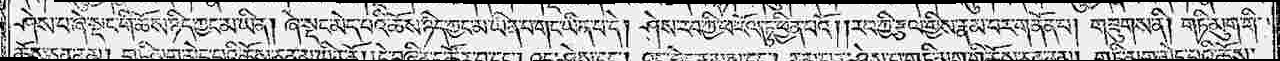

In [14]:
gt_lbl = read_label(gt_lines[line_idx])

ocr_output, _ = viterbi_search(np_predictions, old_pred_charset)
unicode_output = converter.toUnicode(ocr_output)
print(f"OCR: {unicode_output}")
print(f"Label: {gt_lbl}")
cer_score = cer_scorer.compute(predictions=[unicode_output], references=[gt_lbl])
print(f"CER: {cer_score}")

ShowImage(test_lines[line_idx])

#### Run predictions on all test lines and compute CER

In [19]:
cer_scores = []

for image, label in tqdm(zip(test_images, test_labels), total=len(test_images)):

    t_img = prepare_test_image(image)
    lbl = read_label(label)
    
    predictions = inference_model(t_img)
    np_predictions = predictions.cpu().detach().numpy()
    np_predictions = np.squeeze(np_predictions, axis=1)
    ocr_output, _ = viterbi_search(np_predictions, old_pred_charset)
    unicode_ocr = converter.toUnicode(ocr_output)

    cer_score = cer_scorer.compute(predictions=[unicode_ocr], references=[lbl])
    cer_scores.append(cer_score)

100%|██████████| 16064/16064 [2:33:14<00:00,  1.75it/s]  


In [20]:
print(cer_scores)

mean_cer = np.mean(cer_scores)
print(mean_cer)

[0.005847953216374269, 0.012903225806451613, 0.0070921985815602835, 0.0, 0.007352941176470588, 0.012987012987012988, 0.023255813953488372, 0.026490066225165563, 0.0, 0.0, 0.015873015873015872, 0.0, 0.029585798816568046, 0.012738853503184714, 0.014705882352941176, 0.006666666666666667, 0.006211180124223602, 0.006172839506172839, 0.007352941176470588, 0.007246376811594203, 0.02127659574468085, 0.013333333333333334, 0.0, 0.0, 0.0, 0.006578947368421052, 0.006535947712418301, 0.013245033112582781, 0.007352941176470588, 0.006578947368421052, 0.014705882352941176, 0.006369426751592357, 0.014492753623188406, 0.006896551724137931, 0.0, 0.0, 0.0, 0.014184397163120567, 0.019867549668874173, 0.0, 0.013888888888888888, 0.006211180124223602, 0.0, 0.0, 0.013422818791946308, 0.0, 0.04424778761061947, 0.0, 0.0, 0.0273972602739726, 0.0, 0.0, 0.0, 0.03289473684210526, 0.0, 0.013513513513513514, 0.006666666666666667, 0.02027027027027027, 0.0, 0.0, 0.013605442176870748, 0.0, 0.006097560975609756, 0.0059171

In [12]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

#### Export to ONNX

In [7]:
import torch.onnx

from onnxruntime.quantization import QuantType  # type: ignore
from onnxruntime.quantization.quantize import quantize_dynamic

In [13]:
batch_size = 1
x = torch.randn([1, 1, 80, 2000], device=DEVICE, requires_grad=True)
inference_model.to(DEVICE)
#model_input =  torch.randn([1, 3, PATCH_SIZE, PATCH_SIZE], device=DEVICE)

# Export the model
torch.onnx.export(inference_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  f"{checkpoint_path}/LhasaKanjur_Torch_gpu.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=17,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

c:\Users\Eric\miniconda3\envs\pytorch\lib\site-packages\torch\onnx\symbolic_opset9.py:4476: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [14]:
quantize_dynamic(
            model_input=f"{checkpoint_path}/LhasaKanjur_Torch_gpu.onnx",
            model_output=f"{checkpoint_path}/LhasaKanjur_Torch_gpu_q.onnx",
            optimize_model=True,
            per_channel=False,
            reduce_range=False,
            weight_type=QuantType.QUInt8,
        )

INFO:root:Quantization parameters for tensor:"input" not specified
INFO:root:Quantization parameters for tensor:"/max_pool_0/MaxPool_output_0" not specified
INFO:root:Quantization parameters for tensor:"/max_pool_1/MaxPool_output_0" not specified
INFO:root:Quantization parameters for tensor:"/conv_block_2/Relu_output_0" not specified
INFO:root:Quantization parameters for tensor:"/max_pool_2/MaxPool_output_0" not specified
INFO:root:Quantization parameters for tensor:"/conv_block_4/Relu_output_0" not specified
INFO:root:Quantization parameters for tensor:"/max_pool_3/MaxPool_output_0" not specified
INFO:root:Quantization parameters for tensor:"/Transpose_output_0" not specified
INFO:root:Quantization parameters for tensor:"/rnn2/Reshape_output_0" not specified
